## Proyecto EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datasets
df_meta = pd.read_csv('../data/games.csv')
df_sales = pd.read_csv('../data/vgsales.csv') # El nombre depende del que bajes

# Previsualización
df_meta.head()

,id,title,releaseDate,rating,genres,description,platforms,metascore,metascore_count,metascore_sentiment,userscore,userscore_count,userscore_sentiment,platform_metascores,developer,publisher
0,1300001290,The Legend of Zelda: Ocarina of Time,1998-11-23,E,Open-World Action,"As a young boy, Link is tricked by Ganondorf, ...",Nintendo 64,99.0,22.0,Universal acclaim,91.0,10611,Universal acclaim,99,Nintendo,"Nintendo,Gradiente"
1,1300001928,SoulCalibur,1999-09-08,T,3D Fighting,"[Xbox Live Arcade] Soulcalibur, the highest M...","Dreamcast,iOS (iPhone/iPad),Xbox 360",98.0,24.0,Universal acclaim,78.0,605,Generally favorable,"98,73,79",Namco,Namco
2,1300027043,Grand Theft Auto IV,2008-04-29,M,Open-World Action,[Metacritic's 2008 PS3 Game of the Year; Also ...,"PlayStation 3,Xbox 360,PC",98.0,86.0,Universal acclaim,83.0,4781,Generally favorable,"98,98,90",Rockstar North,"Rockstar Games,Capcom"
3,1300019237,Super Mario Galaxy,2007-11-12,E,3D Platformer,[Metacritic's 2007 Wii Game of the Year] The u...,Wii,97.0,73.0,Universal acclaim,91.0,4181,Universal acclaim,97,Nintendo,Nintendo
4,1300044129,Super Mario Galaxy 2,2010-05-23,E,3D Platformer,"Super Mario Galaxy 2, the sequel to the galaxy...",Wii,97.0,87.0,Universal acclaim,90.0,2933,Universal acclaim,97,Nintendo EAD Tokyo,"Nintendo,iQue"


In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13442 entries, 0 to 13441
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   13442 non-null  int64  
 1   title                13442 non-null  object 
 2   releaseDate          13410 non-null  object 
 3   rating               11328 non-null  object 
 4   genres               13442 non-null  object 
 5   description          13394 non-null  object 
 6   platforms            13436 non-null  object 
 7   metascore            13436 non-null  float64
 8   metascore_count      13436 non-null  float64
 9   metascore_sentiment  13436 non-null  object 
 10  userscore            13442 non-null  float64
 11  userscore_count      13442 non-null  int64  
 12  userscore_sentiment  11934 non-null  object 
 13  platform_metascores  13436 non-null  object 
 14  developer            13433 non-null  object 
 15  publisher            13440 non-null 

In [9]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [3]:
df_meta['title'].unique()

array(['The Legend of Zelda: Ocarina of Time', 'SoulCalibur',
       'Grand Theft Auto IV', ..., 'Vroom in the Night Sky', 'Yaris',
       'Family Party: 30 Great Games Obstacle Arcade'],
      shape=(13442,), dtype=object)

In [11]:
# 1. Limpiar espacios en blanco en los nombres
df_meta['title'] = df_meta['title'].str.strip()
df_sales['Name'] = df_sales['Name'].str.strip()

# 2. Unir los DataFrames por nombre y plataforma
# Nota: A veces las plataformas se llaman distinto (ej: "PS4" vs "PlayStation 4"), 
# asegúrate de mapearlas si es necesario.
df_combined = pd.merge(df_meta, df_sales, left_on=['title', 'platforms'], right_on=['Name', 'Platform'], how='inner')

# 3. Limpiar puntuaciones de usuario (Metacritic a veces tiene "tbd")
df_combined = df_combined[df_combined['userscore'] != 'tbd']
df_combined['userscore'] = df_combined['userscore'].astype(float)

# 4. Escalar el User Score (0-10) a la misma escala que el Critic Score (0-100)
df_combined['user_score_100'] = df_combined['userscore'] * 10

In [4]:
# Seleccionar columnas numéricas para correlación
print(df_combined.columns)
cols_corr = ['metascore', 'userscore', 'Global_Sales', 'critics', 'users']
correlation_matrix = df_combined[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Matriz de Correlación: Calidad vs Ventas')
plt.show()

NameError: name 'df_combined' is not defined

In [5]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_combined, x='score', y='Global_Sales', alpha=0.6, hue='Genre')
plt.title('Relación entre Puntuación de la Crítica y Ventas Globales')
plt.xlabel('Metascore (Crítica)')
plt.ylabel('Ventas Globales (Millones)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

NameError: name 'df_combined' is not defined

<Figure size 1200x600 with 0 Axes>

In [6]:
# Calcular la diferencia (Prensa - Usuarios)
df_combined['opinion_gap'] = df_combined['score'] - df_combined['user_score_100']

# Top 10 juegos más "odiados" por el público pero amados por la prensa
polemicos = df_combined.sort_values(by='opinion_gap', ascending=False).head(10)
print(polemicos[['name', 'score', 'user_score_100', 'opinion_gap']])

NameError: name 'df_combined' is not defined

In [7]:
# --- CLASIFICACIÓN POR CUADRANTES ---
def clasificar_juego(row):
    if row['score'] >= 85 and row['user_score_100'] >= 85:
        return 'Obra Maestra'
    elif row['score'] >= 85 and row['user_score_100'] < 70:
        return 'Favorito de la Crítica (Polémico)'
    elif row['score'] < 70 and row['user_score_100'] >= 85:
        return 'Favorito del Público (Culto)'
    else:
        return 'Promedio/Bajo'

df_combined['categoria_exito'] = df_combined.apply(clasificar_juego, axis=1)

# Visualización de los Cuadrantes
plt.figure(figsize=(10,6))
sns.boxplot(x='categoria_exito', y='Global_Sales', data=df_combined)
plt.title('Ventas Globales según la Percepción Crítica vs Público')
plt.yscale('log') # Usamos escala logarítmica si hay mucha diferencia en ventas
plt.show()

# --- ANÁLISIS DE VENTAS POR DÉCADA ---
df_combined['year'] = pd.to_datetime(df_combined['r-date']).dt.year
ventas_tiempo = df_combined.groupby('year')['Global_Sales'].sum()
score_tiempo = df_combined.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.bar(ventas_tiempo.index, ventas_tiempo, alpha=0.3, color='blue', label='Ventas')
ax2.plot(score_tiempo.index, score_tiempo, color='red', marker='o', label='Calidad Media')
plt.title('Evolución de la Calidad vs Volumen de Ventas a través de los años')
plt.show()

NameError: name 'df_combined' is not defined

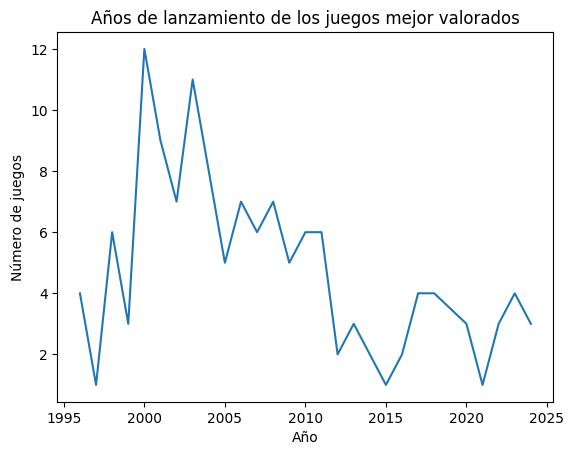

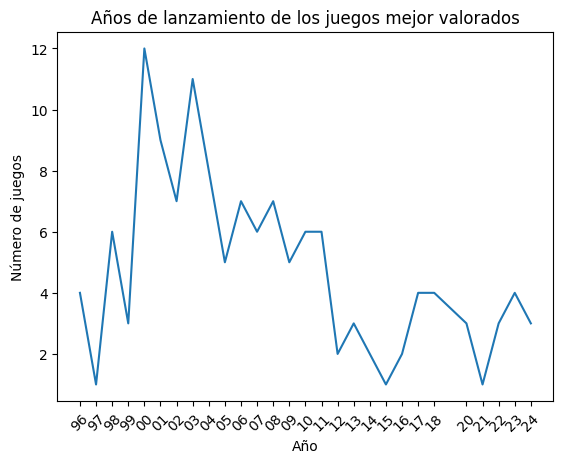

In [8]:
df_meta['releaseDate'] = pd.to_datetime(df_meta['releaseDate'], errors='coerce')
df_meta['year'] = df_meta['releaseDate'].dt.year.astype('Int64')

threshold = df_meta['metascore'].quantile(0.99)

top_1_percent = df_meta[df_meta['metascore'] >= threshold]

top_1_percent['year'].value_counts().sort_index().plot(
    title='Años de lanzamiento de los juegos mejor valorados',
    xlabel='Año',
    ylabel='Número de juegos'
)

counts = top_1_percent['year'].value_counts().sort_index()
fig, ax = plt.subplots()

ax.plot(counts.index, counts.values)
ax.set_xticks(counts.index)
ax.set_xticklabels([f"{year % 100:02d}" for year in counts.index], rotation=45)

ax.set_xlabel('Año')
ax.set_ylabel('Número de juegos')
ax.set_title('Años de lanzamiento de los juegos mejor valorados')

plt.show()

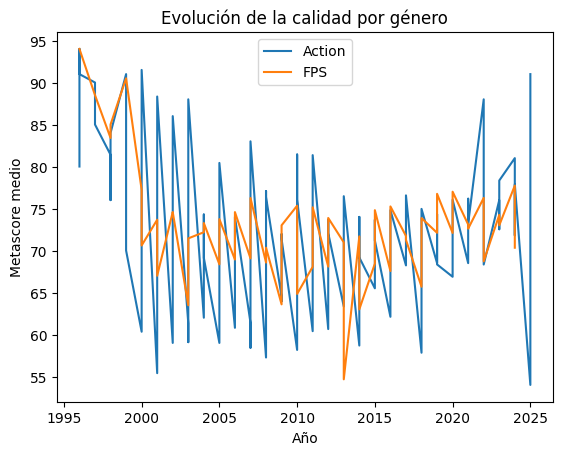

array(['Open-World Action', '3D Fighting', '3D Platformer', 'Skating',
       'FPS', 'Football Sim', 'Linear Action Adventure', 'Survival',
       'Western RPG', 'Compilation', 'Visual Novel', 'Action RPG',
       'Auto Racing Sim', 'Action Adventure', '2D Platformer', 'JRPG',
       'Third Person Shooter', '4X Strategy', 'Third-Person Adventure',
       'Auto Racing', '2D Fighting', 'Real-Time Strategy', 'Arcade',
       'Management', 'Command RTS', 'Skiing', 'Sandbox', 'Soccer Sim',
       'Rhythm', 'Basketball Sim', "2D Beat-'Em-Up", 'Roguelike',
       'Future Racing', 'MMORPG', 'Application', 'Hockey Sim',
       'Virtual Life', 'Turn-Based Tactics', 'Tactical FPS', 'Tennis',
       'Arcade Racing', 'Baseball Sim', 'Metroidvania', 'Party',
       'Aircraft Sim', 'Card Battle', 'Space Combat Sim',
       'Aircraft Combat Sim', 'Vehicle Combat Sim', 'Adventure',
       'Point-and-Click', 'Golf', 'Action Puzzle', 'Tycoon', 'Basketball',
       'Dancing', 'Rail Shooter', 'Action', 'Wr

In [11]:
df_clean = df_meta.dropna(subset=['year', 'metascore', 'genres'])

genres_of_interest = ['Action', 'FPS']

df_genres = df_clean[
    df_clean['genres'].str.contains('|'.join(genres_of_interest), case=False, na=False)
]

quality_by_year = (
    df_genres
    .groupby(['year', 'genres'])['metascore']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots()

for genre in genres_of_interest:
    data = quality_by_year[quality_by_year['genres'].str.contains(genre)]
    ax.plot(data['year'], data['metascore'], label=genre)

ax.set_xlabel('Año')
ax.set_ylabel('Metascore medio')
ax.set_title('Evolución de la calidad por género')
ax.legend()

plt.show()

df_clean['genres'].unique()

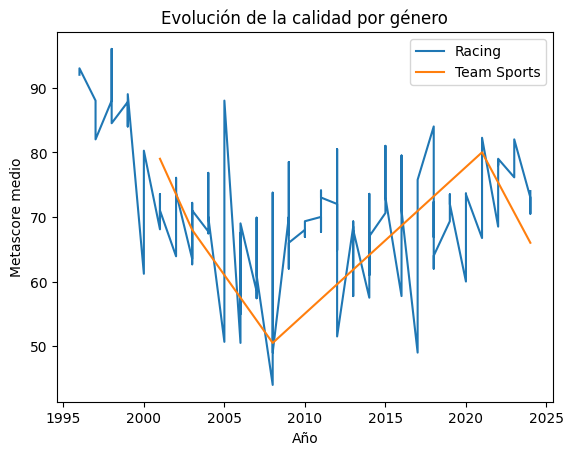

array(['Open-World Action', '3D Fighting', '3D Platformer', 'Skating',
       'FPS', 'Football Sim', 'Linear Action Adventure', 'Survival',
       'Western RPG', 'Compilation', 'Visual Novel', 'Action RPG',
       'Auto Racing Sim', 'Action Adventure', '2D Platformer', 'JRPG',
       'Third Person Shooter', '4X Strategy', 'Third-Person Adventure',
       'Auto Racing', '2D Fighting', 'Real-Time Strategy', 'Arcade',
       'Management', 'Command RTS', 'Skiing', 'Sandbox', 'Soccer Sim',
       'Rhythm', 'Basketball Sim', "2D Beat-'Em-Up", 'Roguelike',
       'Future Racing', 'MMORPG', 'Application', 'Hockey Sim',
       'Virtual Life', 'Turn-Based Tactics', 'Tactical FPS', 'Tennis',
       'Arcade Racing', 'Baseball Sim', 'Metroidvania', 'Party',
       'Aircraft Sim', 'Card Battle', 'Space Combat Sim',
       'Aircraft Combat Sim', 'Vehicle Combat Sim', 'Adventure',
       'Point-and-Click', 'Golf', 'Action Puzzle', 'Tycoon', 'Basketball',
       'Dancing', 'Rail Shooter', 'Action', 'Wr

In [10]:
df_clean = df_meta.dropna(subset=['year', 'metascore', 'genres'])

genres_of_interest = ['Racing', 'Team Sports']

df_genres = df_clean[
    df_clean['genres'].str.contains('|'.join(genres_of_interest), case=False, na=False)
]

quality_by_year = (
    df_genres
    .groupby(['year', 'genres'])['metascore']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots()

for genre in genres_of_interest:
    data = quality_by_year[quality_by_year['genres'].str.contains(genre)]
    ax.plot(data['year'], data['metascore'], label=genre)

ax.set_xlabel('Año')
ax.set_ylabel('Metascore medio')
ax.set_title('Evolución de la calidad por género')
ax.legend()

plt.show()

df_clean['genres'].unique()

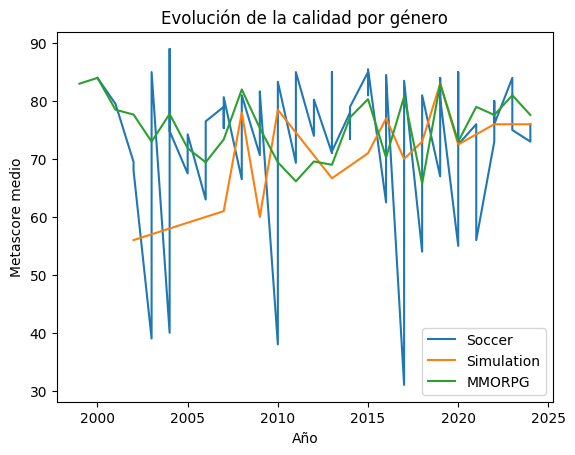

array(['Open-World Action', '3D Fighting', '3D Platformer', 'Skating',
       'FPS', 'Football Sim', 'Linear Action Adventure', 'Survival',
       'Western RPG', 'Compilation', 'Visual Novel', 'Action RPG',
       'Auto Racing Sim', 'Action Adventure', '2D Platformer', 'JRPG',
       'Third Person Shooter', '4X Strategy', 'Third-Person Adventure',
       'Auto Racing', '2D Fighting', 'Real-Time Strategy', 'Arcade',
       'Management', 'Command RTS', 'Skiing', 'Sandbox', 'Soccer Sim',
       'Rhythm', 'Basketball Sim', "2D Beat-'Em-Up", 'Roguelike',
       'Future Racing', 'MMORPG', 'Application', 'Hockey Sim',
       'Virtual Life', 'Turn-Based Tactics', 'Tactical FPS', 'Tennis',
       'Arcade Racing', 'Baseball Sim', 'Metroidvania', 'Party',
       'Aircraft Sim', 'Card Battle', 'Space Combat Sim',
       'Aircraft Combat Sim', 'Vehicle Combat Sim', 'Adventure',
       'Point-and-Click', 'Golf', 'Action Puzzle', 'Tycoon', 'Basketball',
       'Dancing', 'Rail Shooter', 'Action', 'Wr

: 

In [ ]:
df_clean = df_meta.dropna(subset=['year', 'metascore', 'genres'])

genres_of_interest = ['Soccer', 'Simulation', 'MMORPG']

df_genres = df_clean[
    df_clean['genres'].str.contains('|'.join(genres_of_interest), case=False, na=False)
]

quality_by_year = (
    df_genres
    .groupby(['year', 'genres'])['metascore']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots()

for genre in genres_of_interest:
    data = quality_by_year[quality_by_year['genres'].str.contains(genre)]
    ax.plot(data['year'], data['metascore'], label=genre)

ax.set_xlabel('Año')
ax.set_ylabel('Metascore medio')
ax.set_title('Evolución de la calidad por género')
ax.legend()

plt.show()

df_clean['genres'].unique()

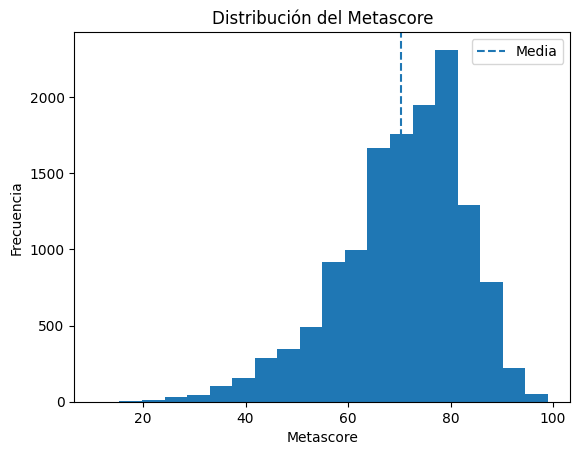

In [13]:
scores = df_meta['metascore'].dropna()

plt.figure()
plt.hist(scores, bins=20)
plt.axvline(scores.mean(), linestyle='--', label='Media')

plt.xlabel('Metascore')
plt.ylabel('Frecuencia')
plt.title('Distribución del Metascore')
plt.legend()
plt.show()

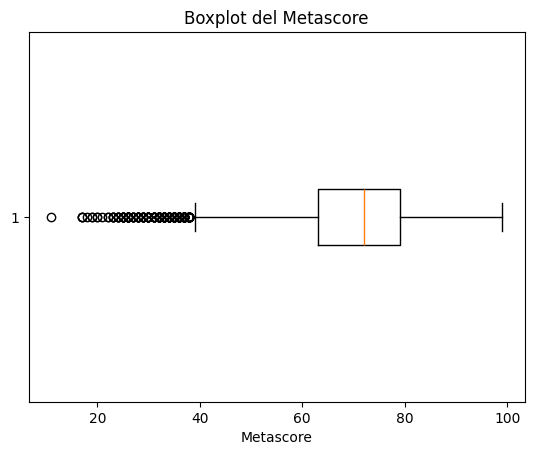

In [14]:
plt.figure()
plt.boxplot(df_meta['metascore'].dropna(), vert=False)
plt.xlabel('Metascore')
plt.title('Boxplot del Metascore')
plt.show()

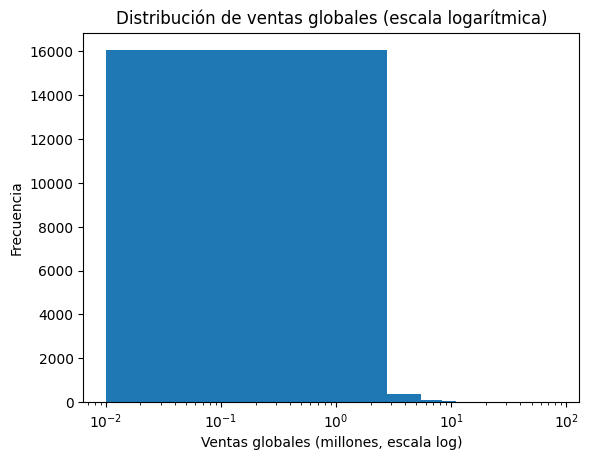

In [15]:
plt.figure()
plt.hist(df_sales['Global_Sales'], bins=30)
plt.xscale('log')
plt.xlabel('Ventas globales (millones, escala log)')
plt.ylabel('Frecuencia')
plt.title('Distribución de ventas globales (escala logarítmica)')
plt.show()

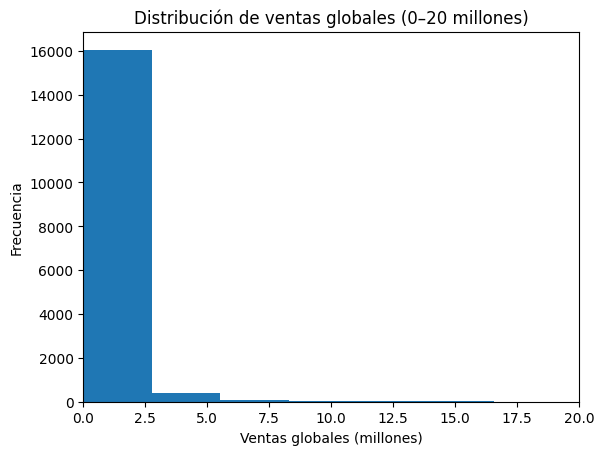

In [17]:
plt.figure()
plt.hist(df_sales['Global_Sales'], bins=30)
plt.xlim(0, 20)
plt.xlabel('Ventas globales (millones)')
plt.ylabel('Frecuencia')
plt.title('Distribución de ventas globales (0–20 millones)')
plt.show()

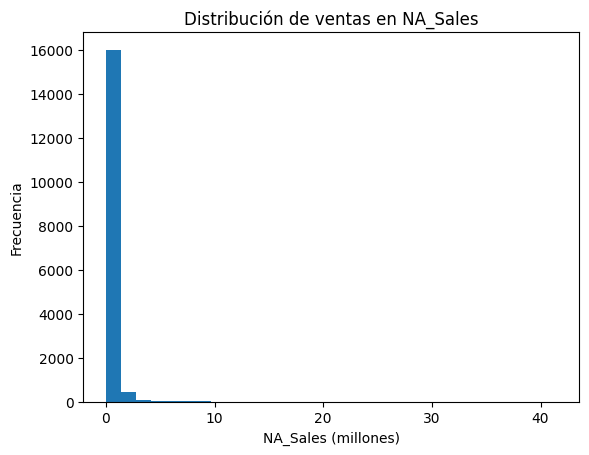

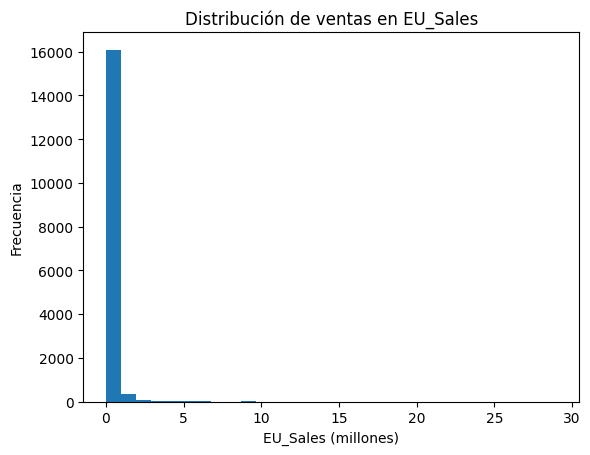

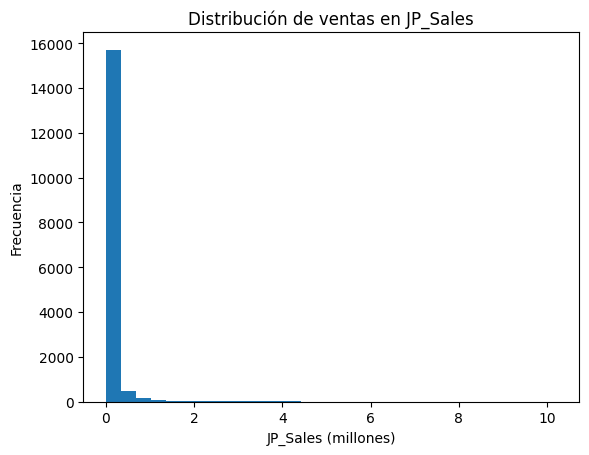

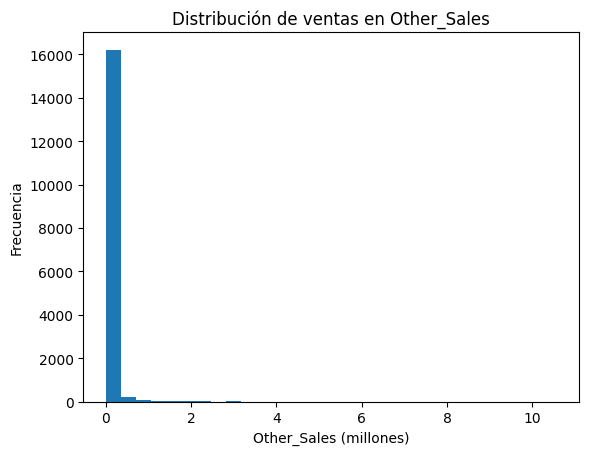

In [19]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for region in regions:
    plt.figure()
    plt.hist(df_sales[region], bins=30)
    plt.xlabel(f'{region} (millones)')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de ventas en {region}')
    plt.show()

C:\Users\Dark Pompa\AppData\Local\Temp\ipykernel_16132\1025868095.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


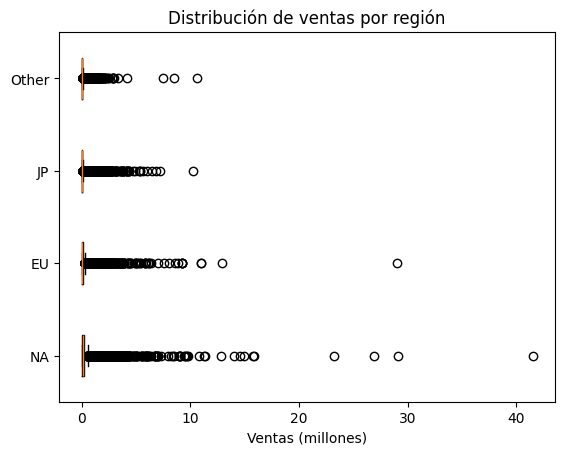

In [20]:
plt.figure()
plt.boxplot(
    [df_sales[r] for r in regions],
    labels=['NA', 'EU', 'JP', 'Other'],
    vert=False
)
plt.xlabel('Ventas (millones)')
plt.title('Distribución de ventas por región')
plt.show()